<a href="https://colab.research.google.com/github/alisonsoong/NASA-SEES-2021-Emergency-Preparedness/blob/main/Wildfire_Group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wildfire - NASA SEES 2021 Emergency Preparedness

Using remote sensing and Google Earth Engine to analyze wildfires and population in California.

Code written by Alison Soong

Research and topography code by Natasha Cordova-Diba


# Import libraries

In [11]:
import ee # Import Earth Engine API
from google.colab import files

In [2]:
## Trigger the authentication flow. You only need to do this once
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=7FZkH_l4aBi0uuHAJqKpXQAiXM9K_g6jSEux13h5pkE&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWg90TUjfYg9-x2XpT0DvAxTsmr3hWCpiCMJPqpPaTXYQVeWpvSx6ug

Successfully saved authorization token.


In [3]:
# Installs geemap package
import subprocess

try:
    import geemap
    print("geemap is imported and ready to use in Colab")
except ImportError:
    print('geemap package not installed. Installing ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])
    import geemap
    print("geemap is now installed, imported and ready to use in Colab") 


geemap is imported and ready to use in Colab


In [4]:
try:
    import geemap
    import os
    import ee
    import seaborn as sns
    import geemap.colormaps as cm
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        # print("package not found, installing w/ pip in Google Colab...")
        !pip install geemap seaborn matplotlib
    else:
        # print("package not found, installing w/ conda...")
        !conda install mamba -c conda-forge -y
        !mamba install geemap -c conda-forge -y
        !conda install seaborn matplotlib -y
    import geemap
    import os
    import ee
    import seaborn as sns
    import geemap.colormaps as cm
    import matplotlib.pyplot as plt

In [13]:
try:
  import numpy as np
  import geemap
  import ee
  import seaborn as sns
  import matplotlib.pyplot as plt
  ee.Initialize()
except Exception as e:
  ee.Authenticate()
  ee.Initialize()

# Population versus Burn Scars Notes

Datasets used:
- https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop#bands (population)
- https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD64A1 (burn scars)

# California Population Versus Wildfire Burn Areas

In [5]:
california_area = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.eq('NAME', 'California'))

In [6]:
# population grid
popdataset2020 = ee.ImageCollection("WorldPop/GP/100m/pop")\
    .filterDate("2020-01-01", "2021-01-01")

pop2020 = popdataset2020.mean().clip(california_area)

pop_params = {
  'bands': ['population'],
  'min': 1.0,
  'max': 60.0,
  'palette' : ['bdd7e7','6baed6','2171b5']
}

popdataset2001 = ee.ImageCollection("WorldPop/GP/100m/pop")\
    .filterDate("2001-01-01", "2002-01-01")

pop2001 = popdataset2001.mean().clip(california_area)


In [7]:
# burned
burnedCollection2020 = ee.ImageCollection('MODIS/006/MCD64A1').filter(ee.Filter.date('2020-01-01', '2021-01-01'))

burned2020 = burnedCollection2020.select('BurnDate').mean().clip(california_area)

burned_params = {
  'min': 30.0,
  'max': 341.0,
  'palette':['red']
}

burnedCollection2001 = ee.ImageCollection('MODIS/006/MCD64A1').filter(ee.Filter.date('2001-01-01', '2002-01-01'))

burned2001 = burnedCollection2001.select('BurnDate').mean().clip(california_area)

In [8]:
# practice with reducing population grid to only burned areas, and to add values
def mask(image):
  empty = 0
  qa = image.select('population');
  popMask = qa.neq(0) # masking out areas that have 0 population
  burnedMask = burned2020.select('BurnDate').neq(0) # masking out areas that were not burned
  mask = popMask.And(burnedMask) # only keep areas that were both burned and have a population
  return image.updateMask(mask).select("population").copyProperties(image, ['population'])

burnedpop2020 = popdataset2020.map(mask)

def mask(image):
  empty = 0
  qa = image.select('population');
  popMask = qa.neq(0) # masking out areas that have 0 population
  burnedMask = burned2001.select('BurnDate').neq(0) # masking out areas that were not burned
  mask = popMask.And(burnedMask) # only keep areas that were both burned and have a population
  return image.updateMask(mask).select("population").copyProperties(image, ['population'])

burnedpop2001 = popdataset2001.map(mask)

impacted_pop_params = {
  'bands': ['population'],
  'min': 0.0,
  'max': 60.0,
  'palette' : ['white','bdd7e7','6baed6','2171b5']
}

# not exactly sure what's going wrong here?
popSum = burnedpop2020.reduce(ee.Reducer.sum())

sumDictionary = popSum.reduceRegion(**{
  'reducer': ee.Reducer.sum(),
  'geometry': california_area,
  'scale': 100,
  'maxPixels': 1e12
})

print('Population affected in 2020:', sumDictionary.getInfo()['population_sum'])

totalPopSum = pop2020.reduce(ee.Reducer.sum())

sumTotalDictionary = totalPopSum.reduceRegion(**{
  'reducer': ee.Reducer.sum(),
  'geometry': california_area,
  'scale': 100,
  'maxPixels': 1e12
})

print('Total population in California 2020:', sumTotalDictionary.getInfo()['sum'])

print('Percent of population affected by wildfires in 2020:\n ', sumDictionary.getInfo()['population_sum']/sumTotalDictionary.getInfo()['sum']*100, '%', sep='')


Population affected in 2020: 28111.26220767843
Total population in California 2020: 35521219.45021494
Percent of population affected by wildfires in 2020:
 0.07913935006391884%


In [9]:
curBurned = ee.ImageCollection('MODIS/006/MCD64A1').filter(ee.Filter.date('2018-01-01', '2019-01-01')).mean().clip(california_area)
result = {"affected":[],"total":[],"percent":[], "year": []};

# reduce population grid to only burned areas, and add values
def maskProcess(image):
  qa = image.select('population');
  popMask = qa.neq(0) # masking out areas that have 0 population
  global curBurned
  burnedMask = curBurned.select('BurnDate').neq(0) # masking out areas that were not burned
  mask = popMask.And(burnedMask) # only keep areas that were both burned and have a population
  return image.updateMask(mask).select("population").copyProperties(image, ['population'])

# Map2 = geemap.Map()

def process(year):
    firstDate = str(year)+'-01-01'
    secondDate = str(year+1)+'-01-01'
    popdataset = ee.ImageCollection("WorldPop/GP/100m/pop").filterDate(firstDate, secondDate)
    pop = popdataset.mean().clip(california_area)
    burnedCollection = ee.ImageCollection('MODIS/006/MCD64A1').filter(ee.Filter.date(firstDate, secondDate))
    global curBurned
    curBurned = burnedCollection.select('BurnDate').mean().clip(california_area)
    burnedpop = popdataset.map(maskProcess)
    # Map2.addLayer(curBurned, burned_params, 'Burned Area ' + str(year), False, 0.6)
    # Map2.addLayer(pop, pop_params, 'pop ' + str(year), False)
    # Map2.addLayer(burnedpop, impacted_pop_params, 'Impacted Population ' + str(year), False) 
    popSum = burnedpop.reduce(ee.Reducer.sum())
    sumDictionary = popSum.reduceRegion(**{
      'reducer': ee.Reducer.sum(),
      'geometry': california_area,
      'scale': 100,
      'maxPixels': 1e12
    })
    totalPopSum = pop.reduce(ee.Reducer.sum())
    sumTotalDictionary = totalPopSum.reduceRegion(**{
      'reducer': ee.Reducer.sum(),
      'geometry': california_area,
      'scale': 100,
      'maxPixels': 1e12
    })
    # print(year)
    # print('Population affected: ', sumDictionary.getInfo()['population_sum'], sep='')
    # print('Total population in California: ', sumTotalDictionary.getInfo()['sum'], sep='')
    # print('Percent of population affected by wildfires: ', sumDictionary.getInfo()['population_sum']/sumTotalDictionary.getInfo()['sum']*100, '%', sep='')
    global result
    result['affected'].append(int(sumDictionary.getInfo()['population_sum']))
    result['total'].append(int(sumTotalDictionary.getInfo()['sum']))
    result['percent'].append(sumDictionary.getInfo()['population_sum']/sumTotalDictionary.getInfo()['sum']*100)
    result['year'].append(int(year))

# Map it
roi = ee.Geometry.Point(-122.438005, 37.729844) # (long, lat)

# Map2.add_basemap("SATELLITE")

# legend for population
legend_dict = {
    'No population': '000000',
    'Low population':'6baed6',
    'High population': '2171b5',
    'Area with population affected by wildfires': 'ffffff',
    'Burn areas': 'ff0000'
}

# Map2.add_legend(legend_title="Population and Burn Scars", legend_dict=legend_dict)

for i in range(2000,2021):
  process(i)

print(result['affected'])
print(result['total'])
print(result['percent'])
print(result['year'])


[11, 5884, 3502, 57035, 7762, 8615, 5895, 44939, 31220, 24150, 1908, 1297, 684, 7203, 9423, 7620, 7002, 63678, 70648, 19699, 28111]
[29137226, 29406597, 29680576, 29959237, 30242692, 30530239, 30823665, 31122485, 31425782, 31734751, 32047985, 32367664, 32692120, 33023132, 33360967, 33704305, 34054437, 34410745, 34774456, 35143968, 35521219]
[4.096482834400055e-05, 0.020012376435003677, 0.011802133268174751, 0.190375890545677, 0.0256680199924441, 0.02821866191825336, 0.01912714380927015, 0.1443963462463478, 0.09934581998079074, 0.0761014342062153, 0.005954472077444485, 0.004009197996711395, 0.00209512631282397, 0.021813406615140536, 0.028247856431884044, 0.022609380656061585, 0.020562325187759127, 0.1850537438787398, 0.20316141801515883, 0.05605506454989155, 0.07913935006391884]
[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [17]:
# Final values: (since the above code is, unfortunately, slow)
result['affected'] = [11, 5884, 3502, 57035, 7762, 8615, 5895, 44939, 31220, 24150, 1908, 1297, 684, 7203, 9423, 7620, 7002, 63678, 70648, 19699, 28111]
result['total'] = [29137226, 29406597, 29680576, 29959237, 30242692, 30530239, 30823665, 31122485, 31425782, 31734751, 32047985, 32367664, 32692120, 33023132, 33360967, 33704305, 34054437, 34410745, 34774456, 35143968, 35521219]
result['percent'] = [4.096482834400055e-05, 0.020012376435003677, 0.011802133268174751, 0.190375890545677, 0.0256680199924441, 0.02821866191825336, 0.01912714380927015, 0.1443963462463478, 0.09934581998079074, 0.0761014342062153, 0.005954472077444485, 0.004009197996711395, 0.00209512631282397, 0.021813406615140536, 0.028247856431884044, 0.022609380656061585, 0.020562325187759127, 0.18505374387873985, 0.20316141801515886, 0.05605506454989155, 0.07913935006391884]
result['year'] = [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

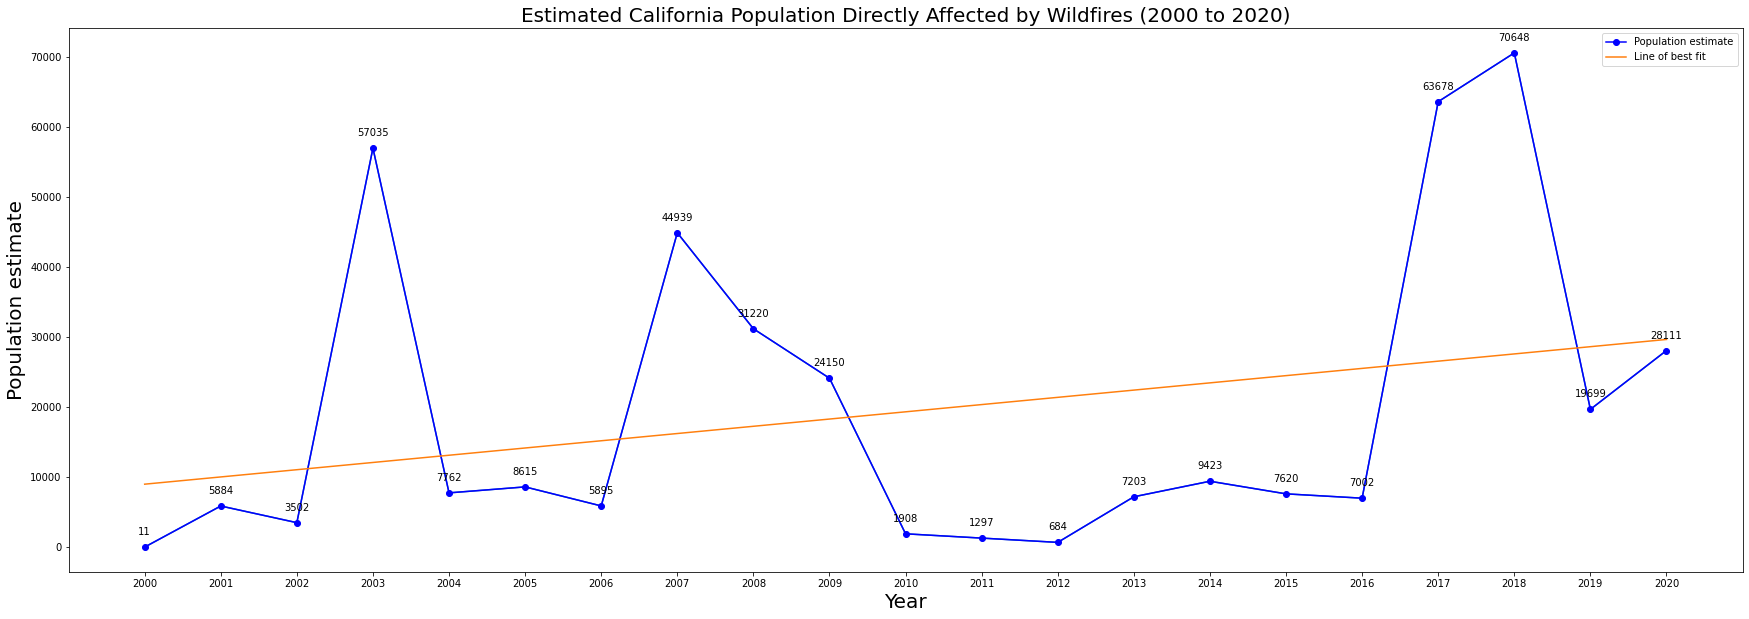

<Figure size 432x288 with 0 Axes>

In [15]:
# create a pyplot figure
fig, ax = plt.subplots(figsize=(30,10))

sns.lineplot(x=result['year'],y=result['affected'], ax=ax)

plt.xticks(np.arange(2000, 2020+1, 1.0))

# set the labels and title
ax.set_ylabel('Population estimate',fontsize=20)
ax.set_xlabel('Year',fontsize=20)
ax.set_title('Estimated California Population Directly Affected by Wildfires (2000 to 2020)',fontsize=20);

plt.plot(result['year'],result['affected'],'bo-', label='Population estimate')

# zip joins x and y coordinates in pairs
for x,y in zip(result['year'],result['affected']):
    label = y
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,12), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

x = np.arange(2000, 2020+1, 1.0)

y = result['affected']

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, label='Line of best fit')
ax.legend(loc='best')
plt.savefig('popEstimate.pdf', dpi=100)
plt.show()
plt.draw()

# download as pdf 
# files.download('popEstimate.pdf')

In [24]:
# Map it
roi = ee.Geometry.Point(-122.438005, 37.729844) # (long, lat)

Map = geemap.Map()
Map.add_basemap("SATELLITE")

landcover2 = ee.ImageCollection("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS") \
    .filter(ee.Filter.date('1992-01-01', '1992-12-31')).mean()
curImage = landcover2.select('stable_lights')
curImage = curImage.where(curImage.neq(1), 1)
Map.add_layer(curImage,{'palette':['white']},'Background')


landcover = ee.ImageCollection('USGS/NLCD').select('landcover').filterDate("2016-01-01", "2017-01-01").first().clip(california_area)
landcover3 = ee.ImageCollection("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS") \
    .filter(ee.Filter.date('1992-01-01', '1992-12-31')).mean()
curImage = landcover3.select('stable_lights').clip(california_area)
curImage = curImage.updateMask(landcover.neq(11).And(landcover.neq(12)).And(landcover.neq(90)).And(landcover.neq(95)).And(landcover.neq(31)))
curImage = curImage.where(curImage.neq(1), 1)
Map.add_layer(curImage,{'palette':['a4a7ab']},'california')

# population
worldPop2020 = ee.ImageCollection("WorldPop/GP/100m/pop")\
    .filterDate("2020-01-01", "2020-12-01").select('population').mean().clip(california_area)

worldPop2020 = worldPop2020.updateMask(worldPop2020.gte(5))

worldPop2001 = ee.ImageCollection("WorldPop/GP/100m/pop")\
    .filterDate("2001-01-01", "2002-12-01").select('population').mean().clip(california_area)

worldPop2001 = worldPop2001.updateMask(worldPop2001.gte(5))

pop_params2 = {
  'bands': ['population'],
  'min': 0.0,
  'max': 50.0,
  'palette': ['white','bdd7e7','6baed6','2171b5']
}


Map.addLayer(pop2020, pop_params, "Population 2020", False)
Map.addLayer(burned2020, burned_params, 'Burned Area 2020', True, 0.6)
Map.addLayer(burnedpop2020, impacted_pop_params, "Area of Impacted Population 2020", False)
Map.addLayer(worldPop2020, pop_params2, "Impacted Population Overlay 2020", True)

Map.addLayer(pop2001, pop_params, "Population 2001", False)
Map.addLayer(burned2001, burned_params, 'Burned Area 2001', False, 0.6)
Map.addLayer(burnedpop2001, impacted_pop_params, "Area of Impacted Population 2001", False)
Map.addLayer(worldPop2001, pop_params2, "Impacted Population Overlay 2001", False)

roi = ee.Geometry.Point(-122.438005, 37.729844) # (long, lat)

# legend for population
legend_dict = {
    'No population': '000000',
    'Low population':'6baed6',
    'High population': '2171b5',
    'Area with population affected by wildfires': 'ffffff',
    'Burn areas': 'ff0000'
}

Map.add_legend(legend_title="Population and Burn Scars", legend_dict=legend_dict)

Map.centerObject(roi, 6)
Map.addLayerControl()
Map

# Risk Map Notes

Risk factors used for risk map:
- High temperatures (extreme heat)
- Low humidity
- Topography (slopes versus flag regions)
- High wind speeds
- Vegetation (fuel) and land cover types

Datasets used:
- https://developers.google.com/earth-engine/datasets/catalog/WorldPop_GP_100m_pop#bands (population)
- https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD64A1 (burn scars)
- https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR (Landsat 8 imagery, vegetation)
- https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET#bands (humidity, temperature, wind)
- https://developers.google.com/earth-engine/datasets/catalog/CSP_ERGo_1_0_US_landforms (landforms/topography)
- https://www.usgs.gov/centers/eros/science/national-land-cover-database?qt-science_center_objects=0#qt-science_center_objects (land cover)
- https://developers.google.com/earth-engine/datasets/catalog/TIGER_2018_States (clipping by state, geometry)


# Wildfire Risk Map

In [20]:
california_area = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.eq('NAME', 'California'))

In [38]:
# Land cover classification

legend_dict = {
    '11 Open Water': '466b9f',
    '12 Perennial Ice/Snow': 'd1def8',
    '21 Developed, Open Space': 'dec5c5',
    '22 Developed, Low Intensity': 'd99282',
    '23 Developed, Medium Intensity': 'eb0000',
    '24 Developed High Intensity': 'ab0000',
    '31 Barren Land (Rock/Sand/Clay)': 'b3ac9f',
    '41 Deciduous Forest': '68ab5f',
    '42 Evergreen Forest': '1c5f2c',
    '43 Mixed Forest': 'b5c58f',
    '51 Dwarf Scrub': 'af963c',
    '52 Shrub/Scrub': 'ccb879',
    '71 Grassland/Herbaceous': 'dfdfc2',
    '72 Sedge/Herbaceous': 'd1d182',
    '73 Lichens': 'a3cc51',
    '74 Moss': '82ba9e',
    '81 Pasture/Hay': 'dcd939',
    '82 Cultivated Crops': 'ab6c28',
    '90 Woody Wetlands': 'b8d9eb',
    '95 Emergent Herbaceous Wetlands': '6c9fb8'
}

# most recent data available
landcover = ee.ImageCollection('USGS/NLCD').select('landcover').filterDate("2016-01-01", "2017-01-01").first().clip(california_area)

#### Land cover scoring! ####
lcCur = landcover.select('landcover')
lcZero = lcCur.updateMask(lcCur.eq(11).Or(lcCur.eq(12)).Or(lcCur.eq(24)).Or(lcCur.eq(31)).Or(lcCur.eq(90)).Or(lcCur.eq(95)))
lcOne = lcCur.updateMask(lcCur.eq(21).Or(lcCur.eq(22)).Or(lcCur.eq(23)))
lcTwo = lcCur.updateMask(lcCur.eq(73).Or(lcCur.eq(74)).Or(lcCur.eq(81)).Or(lcCur.eq(82)))
lcThree = lcCur.updateMask(lcCur.eq(41).Or(lcCur.eq(42)).Or(lcCur.eq(43)).Or(lcCur.eq(51)).Or(lcCur.eq(52)).Or(lcCur.eq(71)).Or(lcCur.eq(72)))

# individual land cover scoring
lcZero = lcZero.where(lcCur.eq(11).Or(lcCur.eq(12)).Or(lcCur.eq(24)).Or(lcCur.eq(31)).Or(lcCur.eq(90)).Or(lcCur.eq(95)), 0) # water or way too developed
lcOne = lcOne.where(lcCur.eq(21).Or(lcCur.eq(22)).Or(lcCur.eq(23)), 1) # slightly developed
lcTwo = lcTwo.where(lcCur.eq(73).Or(lcCur.eq(74)).Or(lcCur.eq(81)).Or(lcCur.eq(82)), 2)
lcThree = lcThree.where(lcCur.eq(41).Or(lcCur.eq(42)).Or(lcCur.eq(43)).Or(lcCur.eq(51)).Or(lcCur.eq(52)).Or(lcCur.eq(71)).Or(lcCur.eq(72)), 3)

# combined land cover scoring
lcCur = lcCur.where(lcCur.eq(11).Or(lcCur.eq(12)).Or(lcCur.eq(24)).Or(lcCur.eq(31)).Or(lcCur.eq(90)).Or(lcCur.eq(95)), 0) # water or way too developed
lcCur = lcCur.where(lcCur.eq(21).Or(lcCur.eq(22)).Or(lcCur.eq(23)), 1) # slightly developed
lcCur = lcCur.where(lcCur.eq(73).Or(lcCur.eq(74)).Or(lcCur.eq(81)).Or(lcCur.eq(82)), 2)
lcCur = lcCur.where(lcCur.eq(41).Or(lcCur.eq(42)).Or(lcCur.eq(43)).Or(lcCur.eq(51)).Or(lcCur.eq(52)).Or(lcCur.eq(71)).Or(lcCur.eq(72)), 3)

# mask for areas that are not affected (water, certain marshland, etc)
lcCur = lcCur.updateMask(landcover.neq(11).And(landcover.neq(12)).And(landcover.neq(90)).And(landcover.neq(95)).And(landcover.neq(31)))


In [39]:
# Landsat EVI
imageCollection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR').filterBounds(california_area)

def maskL8sr(imageCollection):
  cloudShadowBitMask = 1 << 3
  cloudsBitMask = 1 << 5

  qa = imageCollection.select('pixel_qa')

  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
        .And(qa.bitwiseAnd(cloudsBitMask).eq(0))

  return imageCollection.updateMask(mask).divide(10000) \
      .select("B[0-9]*") \
      .copyProperties(imageCollection, ["system:time_start"])
      
stepList = ee.List.sequence(2014,2020)

def process_collection(year):
  startDate = ee.Date.fromYMD(year,5,1)
  endDate = ee.Date.fromYMD(year,9,15)
  composite_i = imageCollection.filterDate(startDate, endDate) \
                        .map(maskL8sr) \
                        .median() \
                        .set('system:time_start',startDate)
  return composite_i
filterCollection = stepList.map(process_collection)

yearlyComposites = ee.ImageCollection(filterCollection)

# Add Enhanced Vegetation Index to a function and apply it.
# EVI = 2.5 * ((NIR - Red) / (NIR + 6 * Red – 7.5 * Blue + 1))
def evi(img):
  eviImg = img.select(['B5','B4','B2'],['nir','red','blue'])
  eviImg = eviImg.expression(
      '(2.5 * ((NIR - RED)) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
      {
        'NIR': eviImg.select('nir'),
        'RED': eviImg.select('red'),
        'BLUE': eviImg.select('blue')
      }).rename('EVI')
  return img.addBands(eviImg)

yearlyComposites = yearlyComposites.map(evi)

# Create image collection of yearly composites, selecting the EVI band.
eviCollection = yearlyComposites.select('EVI')

# Create variables for 2019 yearly composite (using past year composite in order to create risk map for 2020)
y2020 = eviCollection.filterDate('2019-01-01','2019-12-31') \
  .first() \
  .clip(california_area)

eviParams = {'min': 0, 'max': 1, 'palette': ['white', 'green']}

#### EVI land scoring! ####
eviCur = y2020.select('EVI')
eviThree = eviCur.updateMask(eviCur.gt(0.50)) # most vegetation, highest risk
eviTwo = eviCur.updateMask(eviCur.gt(0.15).And(eviCur.lte(0.50))) # medium vegetation, medium risk
eviOne = eviCur.updateMask(eviCur.gt(0.05).And(eviCur.lte(0.15))) # low vegetation, low risk
eviZero = eviCur.updateMask(eviCur.gte(0).And(eviCur.lte(0.05))) # no vegetation, no risk

# individual EVI scoring
eviThree = eviThree.where(eviCur.gt(0.50), 3)
eviTwo = eviTwo.where(eviCur.gt(0.15).And(eviCur.lte(0.50)), 2)
eviOne = eviOne.where(eviCur.gt(0.05).And(eviCur.lte(0.15)), 1)
eviZero = eviZero.where(eviCur.gte(0).And(eviCur.lte(0.05)), 0)

# combined EVI
eviCur = eviCur.where(eviCur.gt(0.50), 3)
eviCur = eviCur.where(eviCur.gt(0.15).And(eviCur.lte(0.50)), 2)
eviCur = eviCur.where(eviCur.gt(0.05).And(eviCur.lte(0.15)), 1)
eviCur = eviCur.where(eviCur.gte(0).And(eviCur.lte(0.05)), 0)

# mask for areas that are not affected (water, certain marshland, etc)
eviCur = eviCur.updateMask(landcover.neq(11).And(landcover.neq(12)).And(landcover.neq(90)).And(landcover.neq(95)).And(landcover.neq(31)))


In [40]:
# Population
popdataset2020 = ee.ImageCollection("WorldPop/GP/100m/pop")\
    .filterDate("2020-01-01", "2021-01-01")

pop2020 = popdataset2020.mean().clip(california_area)

pop_params = {
  'bands': ['population'],
  'min': 0.0,
  'max': 60.0,
  'palette' : ['black','bdd7e7','6baed6','2171b5']
}

worldPop = ee.ImageCollection("WorldPop/GP/100m/pop_age_sex_cons_unadj")\
    .filterDate("2020-01-01", "2020-12-01").mean().clip(california_area)

pop_params2 = {
  'bands': ['population'],
  'min': 0.0,
  'max': 50.0,
  'palette': ['ff4000',  'ffbf00', 'ffff00']
}


In [41]:
# Impervious land: most recent data available
impervious = ee.ImageCollection('USGS/NLCD').select('impervious').filterDate("2016-01-01", "2017-01-01").first().clip(california_area)

datamask = impervious
qa = impervious.select('impervious') 
mask = qa.neq(0)
imperviousMasked = impervious.updateMask(mask.unmask()).clip(california_area)

#### Impervious land scoring! ####
imperviousCur = impervious.select('impervious')
imperviousZero = imperviousCur.updateMask(imperviousCur.gt(75)) # most development, least risk
imperviousOne = imperviousCur.updateMask(imperviousCur.gt(0).And(imperviousCur.lte(75))) # medium development, medium risk

# Impervious reducing values to intended risk score (individual)
imperviousZero = imperviousZero.where(imperviousCur.gt(75), 0) # for example, pixels with values over 75 will be reassigned to 0. Because oof masking above, everything else will be 0.
imperviousOne = imperviousOne.where(imperviousCur.gt(0).And(imperviousCur.lte(75)), 1) # for example, pixels with values under 75 will be reassigned to 1. Because oof masking above, everything else will be 0.

# combined Impervious scoring
imperviousCur = imperviousCur.where(imperviousCur.gt(75), 0)
imperviousCur = imperviousCur.where(imperviousCur.gt(0).And(imperviousCur.lte(75)), 1)

# mask for areas that are not affected (water, certain marshland, etc)
imperviousCur = imperviousCur.updateMask(landcover.neq(11).And(landcover.neq(12)).And(landcover.neq(90)).And(landcover.neq(95)).And(landcover.neq(95)))


In [30]:
# burned
burnedCollection2020 = ee.ImageCollection('MODIS/006/MCD64A1').filter(ee.Filter.date('2020-01-01', '2021-01-01'))

burned2020 = burnedCollection2020.select('BurnDate').mean().clip(california_area)

burned_params = {
  'min': 30.0,
  'max': 341.0,
  'palette':['orange', 'red']
}

In [42]:
gridmetDataset = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filter(ee.Filter.date('2020-01-01', '2021-01-15'))

# max temperature
maximumTemperature = gridmetDataset.select('tmmx').mean().clip(california_area)

temp_params = {
  'min': 290.0,
  'max': 314.0,
  'palette': ['d8d8d8', '4addff', '5affa3', 'f2ff89', 'ff725c']
}

#### Temp land scoring! ####

tempCur = maximumTemperature.select('tmmx')
tempThree = tempCur.updateMask(tempCur.gt(305))
tempTwo = tempCur.updateMask(tempCur.gt(300).And(tempCur.lte(305))) 
tempOne = tempCur.updateMask(tempCur.gt(295).And(tempCur.lte(300))) 
tempZero = tempCur.updateMask(tempCur.lte(295)) 

# individual temp scoring
tempThree = tempThree.where(tempCur.gt(305), 3)
tempTwo = tempTwo.where(tempCur.gt(300).And(tempCur.lte(305)), 2)
tempOne = tempOne.where(tempCur.gt(295).And(tempCur.lte(300)), 1)
tempZero = tempZero.where(tempCur.lte(295), 0)

# combined temp
tempCur = tempCur.where(tempCur.gt(305), 3)
tempCur = tempCur.where(tempCur.gt(300).And(tempCur.lte(305)), 2)
tempCur = tempCur.where(tempCur.gt(295).And(tempCur.lte(300)), 1)
tempCur = tempCur.where(tempCur.lte(295).And(tempCur.gt(4)), 0)

# mask for areas that are not affected (water, certain marshland, etc)
tempCur = tempCur.updateMask(landcover.neq(11).And(landcover.neq(12)).And(landcover.neq(90)).And(landcover.neq(95)).And(landcover.neq(31)))

In [43]:
# humidity
minHumid = gridmetDataset.select('rmin').mean().clip(california_area)

humid_params = {
  'min': 0.0,
  'max': 100.0,
  'palette': ['d8d8d8', '4addff', '5affa3', 'f2ff89', 'ff725c']
}

#### Humidity land scoring! ####

# 0 to 15 is score 3, 15 to 30 is score 2, 30 to 60 is score 1, above 60 is score 0
humidCur = minHumid.select('rmin')
humidFour = humidCur.updateMask(humidCur.lte(15))
humidThree = humidCur.updateMask(humidCur.gt(15).And(humidCur.lte(30))) 
humidTwo = humidCur.updateMask(humidCur.gt(30).And(humidCur.lte(60))) 
humidOne = humidCur.updateMask(humidCur.gt(60).And(humidCur.lte(80))) 
humidZero = humidCur.updateMask(humidCur.gt(80)) 

# individual humidity scoring
humidFour = humidFour.where(humidCur.lte(15), 4)
humidThree = humidThree.where(humidCur.gt(15).And(humidCur.lte(30)), 3)
humidTwo = humidTwo.where(humidCur.gt(30).And(humidCur.lte(60)), 2)
humidOne = humidOne.where(humidCur.gt(60).And(humidCur.lte(80)), 1)
humidZero = humidZero.where(humidCur.gt(80), 0)

# combined humidity
humidCur = humidCur.where(humidCur.lte(15), 4)
humidCur = humidCur.where(humidCur.gt(15).And(humidCur.lte(30)), 3)
humidCur = humidCur.where(humidCur.gt(30).And(humidCur.lte(60)), 2)
humidCur = humidCur.where(humidCur.gt(60).And(humidCur.lte(80)), 1)
humidCur = humidCur.where(humidCur.gt(80), 0)

# mask for areas that are not affected (water, certain marshland, etc)
humidCur = humidCur.updateMask(landcover.neq(11).And(landcover.neq(12)).And(landcover.neq(90)).And(landcover.neq(95)).And(landcover.neq(31)))

In [44]:
# wind
windVel = gridmetDataset.select('vs').mean().clip(california_area)

wind_params = {
  'min': 0.0,
  'max': 30.0,
  'palette': ['d8d8d8', '4addff', '5affa3', 'f2ff89', 'ff725c']
}

#### wind land scoring! ####

# frequent gusts, of 25 mph or greater. Thus 0-5 is score 0, 6-25 is score 1, and >25 is score 2 for miles per hour
# thus for meters/second -> >11 is score 3, 6-11 is score , 2-6 is score 1, and 0-2 is score 0

windCur = windVel.select('vs')
windThree = windCur.updateMask(windCur.gte(25))
windTwo = windCur.updateMask(windCur.gte(15).And(windCur.lt(25))) 
windOne = windCur.updateMask(windCur.gte(5).And(windCur.lt(15))) 
windZero = windCur.updateMask(windCur.gte(0).And(windCur.lt(5))) 

# individual wind scoring
windThree = windThree.where(windCur.gte(25), 3)
windTwo = windTwo.where(windCur.gte(15).And(windCur.lt(25)), 2)
windOne = windOne.where(windCur.gte(5).And(windCur.lt(15)), 1)
windZero = windZero.where(windCur.gte(0).And(windCur.lt(5)), 0)

# combined wind
windCur = windCur.where(windCur.lt(3), 0)
windCur = windCur.where(windCur.gte(3).And(windCur.lt(5)), 1)
windCur = windCur.where(windCur.gte(5).And(windCur.lt(7)), 2)
windCur = windCur.where(windCur.gte(7), 3)

# mask for areas that are not affected (water, certain marshland, etc)
windCur = windCur.updateMask(landcover.neq(11).And(landcover.neq(12)).And(landcover.neq(90)).And(landcover.neq(95)).And(landcover.neq(31)))


In [45]:
# Landforms
landformDataset = ee.Image('CSP/ERGo/1_0/US/landforms');
landforms = landformDataset.select('constant').clip(california_area);

landformsVis = {
  min: 11.0,
  max: 42.0,
  'palette': [
    '141414', '383838', '808080', 'EBEB8F', 'F7D311', 'AA0000', 'D89382',
    'DDC9C9', 'DCCDCE', '1C6330', '68AA63', 'B5C98E', 'E1F0E5', 'a975ba',
    '6f198c'
  ],
}

#### Landform scoring! ####
landformCur = landforms.select('constant')
landformZero = landformCur.updateMask(landformCur.eq(34).Or(landformCur.eq(33)).Or(landformCur.eq(24)).Or(landformCur.eq(23)).Or(landformCur.eq(15)).Or(landformCur.eq(14)).Or(landformCur.eq(13)))
landformOne = landformCur.updateMask(landformCur.eq(41).Or(landformCur.eq(32)).Or(landformCur.eq(22)).Or(landformCur.eq(12)))
landformTwo = landformCur.updateMask(landformCur.eq(31).Or(landformCur.eq(21)).Or(landformCur.eq(11)))
landformThree = landformCur.updateMask(landformCur.eq(42))

# individual landform scoring
landformZero = landformZero.where(landformCur.eq(34).Or(landformCur.eq(33)).Or(landformCur.eq(24)).Or(landformCur.eq(23)).Or(landformCur.eq(15)).Or(landformCur.eq(14)).Or(landformCur.eq(13)), 0)
landformOne = landformOne.where(landformCur.eq(41).Or(landformCur.eq(32)).Or(landformCur.eq(22)).Or(landformCur.eq(12)), 1)
landformTwo = landformTwo.where(landformCur.eq(31).Or(landformCur.eq(21)).Or(landformCur.eq(11)), 2)
landformThree = landformThree.where(landformCur.eq(42), 3)

# combined landform scoring
landformCur = landformCur.where(landformCur.eq(34).Or(landformCur.eq(33)).Or(landformCur.eq(24)).Or(landformCur.eq(23)).Or(landformCur.eq(15)).Or(landformCur.eq(14)).Or(landformCur.eq(13)), 0)
landformCur = landformCur.where(landformCur.eq(41).Or(landformCur.eq(32)).Or(landformCur.eq(22)).Or(landformCur.eq(12)), 1)
landformCur = landformCur.where(landformCur.eq(31).Or(landformCur.eq(21)).Or(landformCur.eq(11)), 2)
landformCur = landformCur.where(landformCur.eq(42), 3)

# mask for areas that are not affected (water, certain marshland, etc)
landformCur = landformCur.updateMask(landcover.neq(11).And(landcover.neq(12)).And(landcover.neq(90)).And(landcover.neq(95)).And(landcover.neq(31)))



In [46]:
# Risk calculationns
riskImg = ee.Image().clip(california_area)
riskImg = riskImg.select('RISK')

def risk(image, evi, impervious, lc, wind, temp, humidity, landform):
  riskImg = image
  eviCur = evi
  imperviousCur = impervious
  lcCur = lc
  windCur = wind
  tempCur = temp
  humidityCur = humidity
  landformCur = landform
  riskImg = riskImg.expression(
      'evi+lc+wind+temp+humidity+landform',
      {
      'evi': eviCur.select('EVI'),
      'lc': lcCur.select('landcover'),
      # 'impervious': imperviousCur.select('impervious')
      'wind' : windCur.select('vs'),
      'temp' : tempCur.select('tmmx'),
       'humidity' : humidityCur.select('rmin'),
       'landform' : landform.select('constant')
      }).rename('RISK')
  return riskImg

riskImg = risk(riskImg, eviCur, imperviousCur, lcCur, windCur, tempCur, humidCur, landformCur)
riskImg = riskImg.updateMask(riskImg.neq(0))
riskImmg = riskImg.updateMask(landcover.select('landcover').eq(11))
risImg = riskImg.select('RISK')



In [47]:
# Map it!
Map = geemap.Map()

risk_params = {
    'min': 0.0,
    'max': 18.0,
    'palette':['0040ff','4000ff','40ff00', 'bfff00']
}

# creating a white background
Map.add_basemap("SATELLITE")
landcover2 = ee.ImageCollection("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS") \
    .filter(ee.Filter.date('1992-01-01', '1992-12-31')).mean()
curImage = landcover2.select('stable_lights')
curImage = curImage.where(curImage.neq(1), 1)
Map.add_layer(curImage,{'palette':['white']},'Background')

# EVI
Map.addLayer(y2020, eviParams, '2020 EVI', False)

# Population
Map.addLayer(pop2020, pop_params, "Population 2020", False)

# # California land classfication color image
# Map.addLayer(composite, {'bands':['B4','B3','B2'], 'min': 0, 'max': 0.3},'California Color Image', 0);
# # land classification legend
# Map.add_legend(legend_title="Land Cover Classification", legend_dict=legend_dict)
# # Add final map to the display
# Map.addLayer(finalmap.sldStyle(urbanPalette), {}, "Land Classification");

# # Land classification
# Map.addLayer(landcover, {}, 'NLCD Land Cover', False)
# Map.add_legend(title="NLCD Land Cover Classification", legend_dict=legend_dict)

# # Impervious land
# Map.addLayer(imperviousMasked, {}, 'NLCD Impervious Land Cover', False)

# # Impervious land scoring!
# Map.addLayer(imperviousZero, {'min': 0.0, 'max': 1.0, 'palette': ['white', 'black']}, 'ZERO NLCD Impervious Land Cover Masked', False)
# Map.addLayer(imperviousOne, {'min': 0.0, 'max': 1.0, 'palette': ['white', 'black']}, 'ONE NLCD Impervious Land Cover Masked', False)

# # EVI land scoring!
# Map.addLayer(eviZero, {'min': 0.0, 'max': 4.0, 'palette': ['feedde','fdbe85','fd8d3c','d94701']}, 'ZERO EVI', False)
# Map.addLayer(eviOne, {'min': 0.0, 'max': 4.0, 'palette': ['feedde','fdbe85','fd8d3c','d94701']}, 'ONE EVI', False)
# Map.addLayer(eviTwo, {'min': 0.0, 'max': 4.0, 'palette': ['feedde','fdbe85','fd8d3c','d94701']}, 'TWO EVI', False)
# Map.addLayer(eviThree, {'min': 0.0, 'max': 4.0, 'palette': ['feedde','fdbe85','fd8d3c','d94701']}, 'THREE EVI', False)
# # Individual EVI scoring maps
# Map.addLayer(eviZero, {'min': 0.0, 'max': 4.0, 'palette': ['white','ece2f0','a6bddb','1c9099']}, 'ZERO EVI', False)
# Map.addLayer(eviOne, {'min': 0.0, 'max': 4.0, 'palette': ['white','ece2f0','a6bddb','1c9099']}, 'ONE EVI', False)
# Map.addLayer(eviTwo, {'min': 0.0, 'max': 4.0, 'palette': ['white','ece2f0','a6bddb','1c9099']}, 'TWO EVI', False)
# Map.addLayer(eviThree, {'min': 0.0, 'max': 4.0, 'palette': ['white','ece2f0','a6bddb','1c9099']}, 'THREE EVI', False)

# # Individual land cover scoring!
# Map.addLayer(lcZero, {'min': 0.0, 'max': 3.0, 'palette': ['edf8b1','7fcdbb','2c7fb8']}, 'ZERO Land Cover', False)
# Map.addLayer(lcOne, {'min': 0.0, 'max': 3.0, 'palette': ['edf8b1','7fcdbb','2c7fb8']}, 'ONE Land Cover', False)
# Map.addLayer(lcTwo, {'min': 0.0, 'max': 3.0, 'palette': ['edf8b1','7fcdbb','2c7fb8']}, 'TWO Land Cover', False)

# # Temperature
# Map.addLayer(maximumTemperature, temp_params, 'Maximum Temperature', False)
# Map.addLayer(tempCur, {'min': 0, 'max': 3, 'palette': ['ece2f0','a6bddb','1c9099']}, 'masked max temp')

# # Humidity
# Map.addLayer(minHumid, humid_params, 'humidity', False)
# Map.addLayer(humidCur, {'min': 0, 'max': 4, 'palette': ['white','ece2f0','a6bddb','1c9099']}, 'masked min humid')

# # Wind
# Map.addLayer(windVel, wind_params, 'wind vel', False)
# Map.addLayer(windCur, {'min': 0, 'max': 3, 'palette': ['ece2f0','a6bddb','1c9099']}, 'masked wind vel')

# Landforms
# Map.addLayer(landforms, landformsVis, 'Landforms')
# Map.addLayer(landformCur, {'min': 0.0, 'max': 4.0, 'palette': ['white','ece2f0','a6bddb','1c9099']}, 'Landforms masked')

# Map.add_colorbar(colors=['ffffff','ece2f0','a6bddb','1c9099'], vmin=0, vmax=4, caption="Landforms Scoring")


# Risk!
Map.addLayer(riskImg, risk_params, 'Risk 2020', True)

# Burning
Map.addLayer(burned2020, {'palette': ['red']}, 'Burned 2020', True)

legend_burn_dict = {
    'Burned area': 'ff0000'
}
Map.add_legend(title=" ", legend_dict=legend_burn_dict)

# population overlay
Map.addLayer(worldPop, pop_params2, 'Population 2020 Overlay', True)

risk_colorbar = {
  'min': 0,
  'max': 18,
  'palette': ['0040ff','4000ff','40ff00', 'bfff00']
  }

# color bars
Map.add_colorbar(colors=risk_colorbar['palette'], vmin=int(risk_colorbar['min']), vmax=int(risk_colorbar['max']), caption="Risk (low to high)")

Map.add_colorbar(colors=pop_params2['palette'], vmin=int(pop_params2['min']), vmax=int(pop_params2['max']), caption="Population (low to high)")

roi = ee.Geometry.Point(-118.6304, 37.3003) # (long, lat)
Map.centerObject(roi, 6)
Map.addLayerControl()
Map
